# Common raster operations

## Creating a raster mosaic with `rioxarray`

Quite often you need to merge multiple raster files together and create a `raster mosaic`. This can be done easily with the `merge_datasets()` -function in `rioxarray`.
Here, we will create a mosaic based on DEM files (altogether 4 files) covering Kilimanjaro region in Tanzania. First we will read elevation data from a S3 bucket for Kilimanjaro region in Africa.

In [1]:
import xarray as xr
import os
import rioxarray as rxr
from rioxarray.merge import merge_datasets

# S3 bucket containing the data
bucket = "https://a3s.fi/swift/v1/AUTH_0914d8aff9684df589041a759b549fc2/PythonGIS"

# Generate urls for the elevation files
urls = [
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S03E036_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S03E037_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S04E036_dem.tif"),
    os.path.join(bucket, "elevation/kilimanjaro/ASTGTMV003_S04E037_dem.tif"),
]

# Read the files
datasets = [
    xr.open_dataset(url, engine="rasterio").squeeze("band", drop=True) for url in urls
]

Investigate how our data looks like:

In [2]:
datasets[0]

<xarray.Dataset>
Dimensions:      (x: 3601, y: 3601)
Coordinates:
  * x            (x) float64 36.0 36.0 36.0 36.0 36.0 ... 37.0 37.0 37.0 37.0
  * y            (y) float64 -2.0 -2.0 -2.001 -2.001 ... -2.999 -2.999 -3.0 -3.0
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

Visualize the tiles to see how they look like separately:

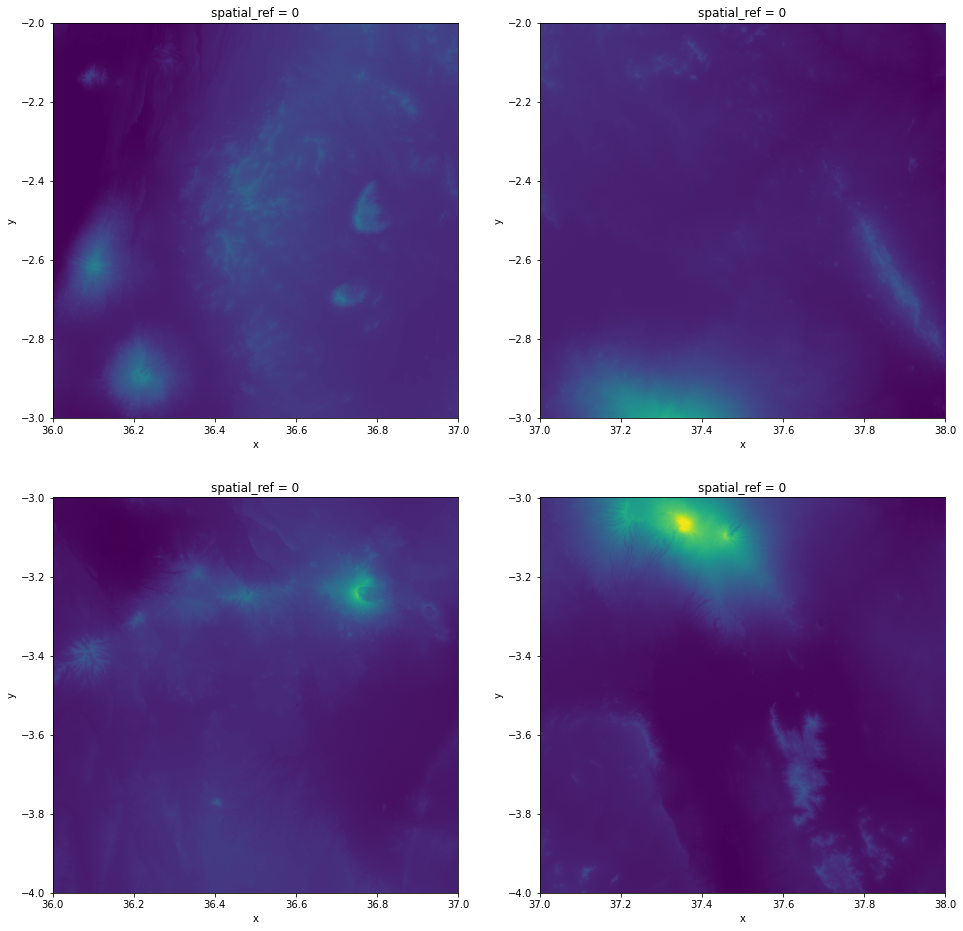

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Plot the tiles to see how they look separately
datasets[0]["band_data"].plot(ax=axes[0][0], vmax=5900, add_colorbar=False)
datasets[1]["band_data"].plot(ax=axes[0][1], vmax=5900, add_colorbar=False)
datasets[2]["band_data"].plot(ax=axes[1][0], vmax=5900, add_colorbar=False)
datasets[3]["band_data"].plot(ax=axes[1][1], vmax=5900, add_colorbar=False)

As we can see we have multiple separate raster files that are actually located next to each other. Hence, we want to put them together into a single raster file that can by done by creating a raster mosaic.
Now we can create a raster mosaic by merging these datasets with `merge_datasets()` function:

In [4]:
# Create a mosaic out of the tiles
mosaic = merge_datasets(datasets)

Rename the data variable to more intuitive one:

In [5]:
# Add a more intuitive name for the data variable
mosaic = mosaic.rename({"band_data": "elevation"})

Plot the end result where the tiles have been merged:

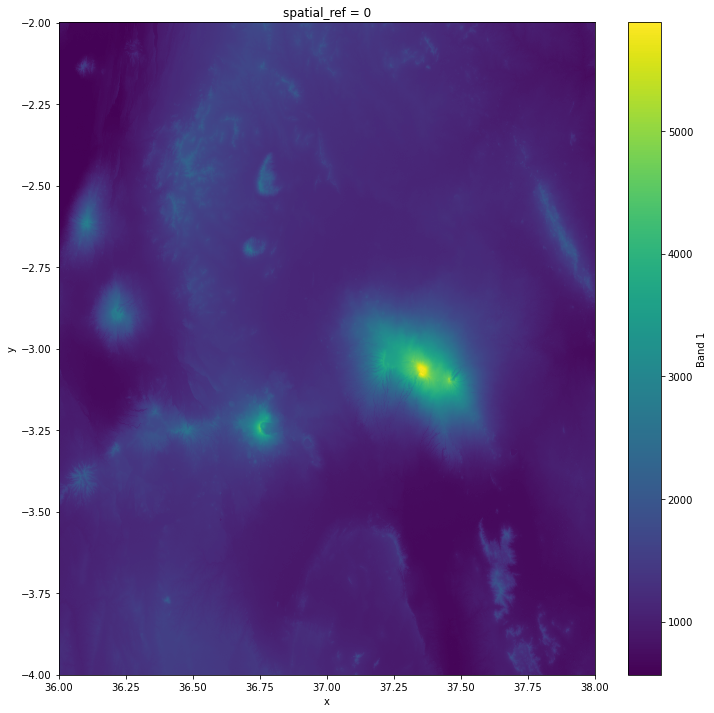

In [6]:
# Plot the mosaic
mosaic["elevation"].plot(figsize=(12, 12))

## Clipping raster

Create a GeoDataFrame with bounding box that we can use for clipping the raster:

In [7]:
import geopandas as gpd
from shapely.geometry import box

# Bounding box coordinates
minx = 37.1
miny = -3.3
maxx = 37.6
maxy = -2.85

# Create a GeoDataFrame that will be used to clip the raster
geom = box(minx, miny, maxx, maxy)
clipping_gdf = gpd.GeoDataFrame({"geometry": [geom]}, index=[0], crs="epsg:4326")

# Explore the extent on a map
clipping_gdf.explore()

Clip the mosaic with GeoDataFrame:

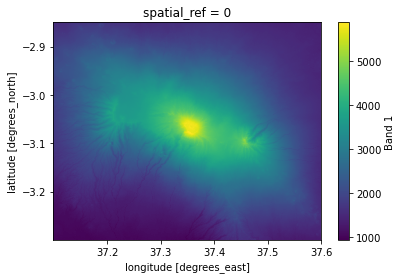

In [8]:
# Clip the Mosaic with GeoDataFrame and specify CRS
kilimanjaro = mosaic.rio.clip(clipping_gdf.geometry, crs=mosaic.elevation.rio.crs)
kilimanjaro["elevation"].plot()

In [9]:
kilimanjaro

<xarray.Dataset>
Dimensions:      (y: 1620, x: 1800)
Coordinates:
  * y            (y) float64 -2.85 -2.85 -2.851 -2.851 ... -3.299 -3.299 -3.3
  * x            (x) float64 37.1 37.1 37.1 37.1 37.1 ... 37.6 37.6 37.6 37.6
    spatial_ref  int64 0
Data variables:
    elevation    (y, x) float32 1.581e+03 1.581e+03 ... 1.295e+03 1.294e+03

Now we have a ready raster mosaic and we can save the raster to a GeoTIFF file:

In [10]:
# Save file to GeoTIFF
kilimanjaro.rio.to_raster("data/kilimanjaro.tif", compress="LZMA", tiled=True)